In [60]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
import joblib

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
df = pd.read_parquet('../datasets/clean.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167677 entries, 0 to 1167676
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   DAY_OF_MONTH       1167677 non-null  int32  
 1   DAY_OF_WEEK        1167677 non-null  int32  
 2   OP_CARRIER         1167677 non-null  object 
 3   OP_CARRIER_FL_NUM  1167677 non-null  int32  
 4   ORIGIN_AIRPORT_ID  1167677 non-null  int32  
 5   ORIGIN             1167677 non-null  object 
 6   DEST_AIRPORT_ID    1167677 non-null  int32  
 7   DEST               1167677 non-null  object 
 8   DEP_TIME           1167677 non-null  float32
 9   DEP_DEL15          1167677 non-null  int32  
 10  DEP_TIME_BLK       1167677 non-null  object 
 11  DISTANCE           1167677 non-null  float32
 12  Air Carrier Name   1167677 non-null  object 
dtypes: float32(2), int32(6), object(5)
memory usage: 80.2+ MB


In [3]:
df.rename(columns={'Air Carrier Name': 'CARRIER'}, inplace=True)

In [4]:
# Frequency Encoding
origin_encoding = df['ORIGIN'].value_counts(normalize=True)
dest_encoding = df['DEST'].value_counts(normalize=True)

df['origin_ap_enc'] = df['ORIGIN'].map(origin_encoding)
df['dest_ap_enc'] = df['DEST'].map(dest_encoding)

In [5]:
df.sample(10)

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,DISTANCE,CARRIER,origin_ap_enc,dest_ap_enc
1044580,25,6,OO,5033,11471,EAU,13930,ORD,1155.0,0,1200-1259,269.0,Skywest Airlines,0.000094,0.041208
1127640,30,4,G4,602,14314,PVU,10466,AZA,1613.0,0,1600-1659,477.0,Allegiant Air LLC,0.000096,0.000804
435671,24,4,DL,2455,11884,GEG,13487,MSP,1405.0,0,1400-1459,1175.0,"Delta Air Lines, Inc.",0.001732,0.020743
88888,5,6,UA,1837,11618,EWR,10423,AUS,2038.0,0,2000-2059,1504.0,"United Airlines, Inc.",0.018515,0.008751
842600,15,3,WN,920,10821,BWI,11057,CLT,857.0,1,0800-0859,361.0,Southwest Airlines,0.013102,0.033104
14919,1,2,WN,1588,14869,SLC,14831,SJC,819.0,0,0800-0859,584.0,Southwest Airlines,0.016661,0.008435
681755,6,1,YX,5903,10721,BOS,12953,LGA,634.0,0,0600-0659,184.0,Republic Airlines,0.019576,0.023224
753433,10,5,DL,1480,13930,ORD,10397,ATL,706.0,0,0700-0759,606.0,"Delta Air Lines, Inc.",0.041299,0.053888
230283,13,7,OH,5235,11617,EWN,11057,CLT,1735.0,0,1700-1759,221.0,Jetstream Intl,0.000320,0.033104
1116357,29,3,DL,1969,12892,LAX,13487,MSP,9.0,0,0001-0559,1535.0,"Delta Air Lines, Inc.",0.030321,0.020743


### Split the dataset

In [6]:
# create a deep copy of the dataframe
df_model = df.copy(deep=True)

In [7]:
df_model.sample(5)

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,DISTANCE,CARRIER,origin_ap_enc,dest_ap_enc
88453,5,6,UA,2394,10721,BOS,11618,EWR,1100.0,0,1100-1159,200.0,"United Airlines, Inc.",0.019576,0.018516
81539,5,6,DL,2760,11433,DTW,10397,ATL,1539.0,0,1500-1559,594.0,"Delta Air Lines, Inc.",0.021326,0.053888
775127,11,6,9E,5049,10397,ATL,15249,TLH,1243.0,0,1200-1259,223.0,Endeavor Air,0.053905,0.000914
460812,25,5,MQ,3944,14952,SPI,11298,DFW,548.0,0,0001-0559,630.0,Envoy Air,0.000211,0.039899
790315,12,7,NK,295,13930,ORD,12266,IAH,2033.0,0,2000-2059,925.0,"Spirit Airlines, Inc.",0.041299,0.024950


In [38]:
# select columns for the model
columns = ['ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST', 'CARRIER', 'DEP_DEL15', 'OP_CARRIER_FL_NUM', 'DEST_AIRPORT_ID'] 
# columns2 = ['ORIGIN_AIRPORT_ID', 'CARRIER', 'DEP_DEL15', 'OP_CARRIER_FL_NUM', 'DEST_AIRPORT_ID'] 
X = df_model.drop(columns, axis=1)
y = df_model['DEP_DEL15']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Scale Numeric values / Encoding obj Columns

In [39]:

numeric_features = X.select_dtypes(include=['int64', 'float64', 'float32', 'int32']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# create transformers for numeric and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


Function to evaluate the models performance

In [41]:
def model_performance(model, y_test, X_test):
    target_names = ['class 0: No delay', 'class 1: Delayed']
    print(classification_report(y_test, model.predict(X_test), target_names=target_names))

    # roc auc score
    roc_auc_score_dc = roc_auc_score(y_test, model.predict(X_test))
    print('roc auc score: {:.2f}'.format(roc_auc_score_dc))

    # confusion matrix
    conf_matrix =  confusion_matrix(y_test, model.predict(X_test), normalize = 'true')
    plt.figure()
    plt.title('Test Confusion Matrix')
    sns.heatmap(conf_matrix, annot = True)


### Logistic Regression model and use of pipelines

In [40]:
# define the model
lr_model = LogisticRegression(solver='liblinear', random_state=2)

# create a pipeline that does the preprocessing and then fits the model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lr_model)])

# fit the model
clf.fit(X_train, y_train)

# evaluate the model
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print(f'Train set accuracy: {train_accuracy*100:.2f}%')
print(f'Test set Accuracy: {test_accuracy*100:.2f}%')

Train set accuracy: 88.47%
Test set Accuracy: 88.50%


                   precision    recall  f1-score   support

class 0: No delay       0.88      1.00      0.94    197572
 class 1: Delayed       1.00      0.25      0.41     35964

         accuracy                           0.89    233536
        macro avg       0.94      0.63      0.67    233536
     weighted avg       0.90      0.89      0.85    233536

roc auc score: 0.63


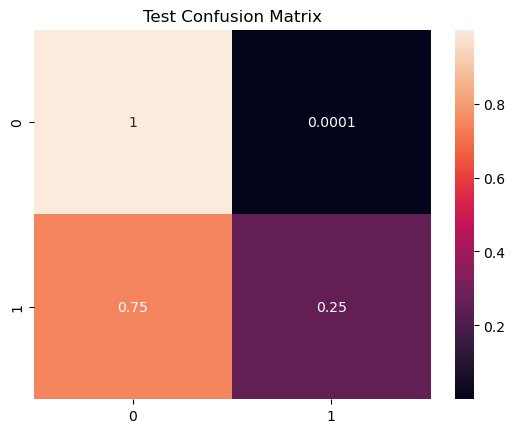

In [42]:
#logistic regression performance
model_performance(clf, y_test, X_test)

In [43]:
# function to quickly evaluate effect of different hyperparameters
# computing time is to be expected
def test_params_lr(**params):
    model = LogisticRegression(random_state=42, **params)

    # create a pipeline that does the preprocessing and then fits the model
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

    # fit the model
    clf.fit(X_train, y_train)

    print('Actual iterations:', clf.named_steps['classifier'].n_iter_)

    train_preds = clf.predict(X_train)
    val_preds = clf.predict(X_test)

    train_accuracy = accuracy_score(y_train, train_preds)
    val_accuracy = accuracy_score(y_test, val_preds)
    
    # train_accuracy = model.score(X_train, y_train)
    # val_accuracy = model.score(X_test, y_test)

    roc_auc_score_lr = roc_auc_score(y_test, clf.predict(X_test))
    print('Train set accuracy: {:.2f}%'.format(train_accuracy*100))
    print('Validation set Accuracy: {:.2f}%'.format(val_accuracy* 100))
    print('roc auc score: {:.2f}'.format(roc_auc_score_lr)) 

# for i in range(1, 20, 2):
#     print('max_iter = ', i)
#     test_params_lr(max_iter=i, solver='liblinear')

### Decision Tree Classifier

In [19]:
# decision tree
dt_model = DecisionTreeClassifier(random_state=42)
# create a pipeline that does the preprocessing and then fits the model
dc_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', dt_model)])
# fit the model
dc_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_TIME', 'DISTANCE', 'origin_ap_enc',
       'dest_ap_enc'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['OP_CARRIER', 'DEP_TIME_BLK'], dtype='object'))])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

              precision    recall  f1-score   support

           0       0.96      0.96      0.96    197572
           1       0.77      0.76      0.77     35964

    accuracy                           0.93    233536
   macro avg       0.87      0.86      0.86    233536
weighted avg       0.93      0.93      0.93    233536

roc auc score: 0.86


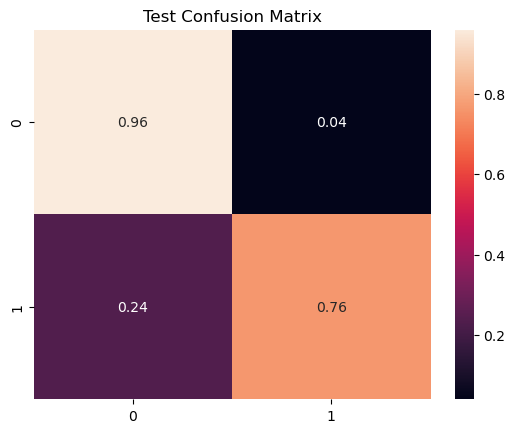

In [25]:
model_performance(dc_pipe, y_test, X_test)

#### Hyperparameter tuning for Decision Tree Classifier

In [27]:
# Hyperparameter tuning function
# its too slow to run on my computer
def decision_tree_grid_search(X_train, y_train):
    
    # Set the parameters you want to grid search over
    params = {
        'classifier__max_depth': [5,10,15,20,25,30],
        'classifier__max_leaf_nodes': [5,10,15,20,25,30],
        'classifier__min_samples_leaf': [1,5,10,15,20,25]
    }

    # Initialize the decision tree model
    dtc = DecisionTreeClassifier()

    # Create a pipeline that does the preprocessing and then fits the model
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', dtc)])

    # Initialize Grid Search and fit the model
    grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    print("Best parameters found: ", grid_search.best_params_)

    return grid_search

# decision_tree_grid_search(X_train, y_train)


In [55]:
param_grid = {
    'classifier__max_depth': range(1, 10)  # Note the format: 'step__parameter'
}

grid = GridSearchCV(dc_pipe, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print("Best parameters: ", grid.best_params_)


Best parameters:  {'classifier__max_depth': 9}


In [56]:
best_params = grid.best_params_

best_max_depth = best_params['classifier__max_depth']
best_model = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42)

best_pipe = Pipeline(steps=[('preprocessor', preprocessor),('classifier', best_model)])
best_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_TIME', 'DISTANCE', 'origin_ap_enc',
       'dest_ap_enc'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['OP_CARRIER', 'DEP_TIME_BLK'], dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=9, random_state=42))])

                   precision    recall  f1-score   support

class 0: No delay       0.90      0.99      0.94    197572
 class 1: Delayed       0.86      0.39      0.54     35964

         accuracy                           0.90    233536
        macro avg       0.88      0.69      0.74    233536
     weighted avg       0.89      0.90      0.88    233536

roc auc score: 0.69


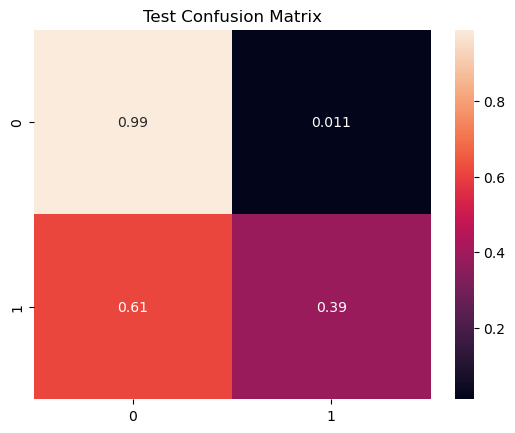

In [57]:
model_performance(best_pipe, y_test, X_test)

### Random Forest Classifier
* warning: this model takes some time to train.

In [58]:
# # define the model
# # TAKES A LOT OF TIME TO RUN

# rf_model = RandomForestClassifier(random_state=42)

# # create a pipeline that does the preprocessing and then fits the model
# rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', rf_model)])

# # # fit the model
# # rf_pipe.fit(X_train, y_train)

# # # evaluate the model
# # train_accuracy = rf_pipe.score(X_train, y_train)
# # test_accuracy = rf_pipe.score(X_test, y_test)

# # print(f'Train set accuracy: {train_accuracy*100:.2f}%')
# # print(f'Test set Accuracy: {test_accuracy*100:.2f}%')

Train set accuracy: 100.00%
Test set Accuracy: 94.03%


                   precision    recall  f1-score   support

class 0: No delay       0.94      0.99      0.97    197572
 class 1: Delayed       0.94      0.65      0.77     35964

         accuracy                           0.94    233536
        macro avg       0.94      0.82      0.87    233536
     weighted avg       0.94      0.94      0.94    233536

roc auc score: 0.82


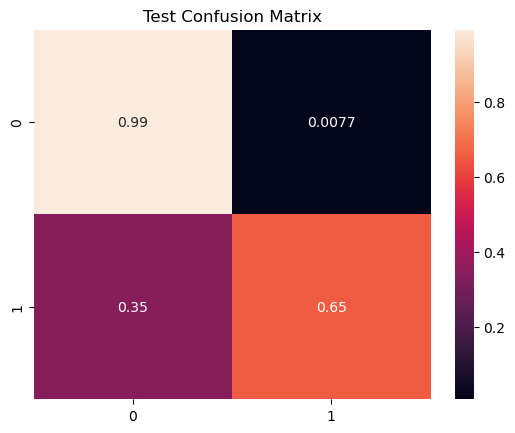

In [59]:
model_performance(rf_pipe, y_test, X_test)

In [62]:
# save the model
# joblib.dump(rf_pipe, '../models/random_forest.joblib')

['../models/random_forest.joblib']

In [65]:
# load_model = joblib.load('../models/random_forest.joblib')

In [64]:
# load_model.score(X_test, y_test)

0.9402704508084406

###  XGBClassifier

In [66]:

def fit_model(X_train, y_train, preprocessor, **model_params):
    # define the model
    xgb_model = XGBClassifier(**model_params)

    # create a pipeline that does the preprocessing and then fits the model
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', xgb_model)])

    # fit the model
    clf.fit(X_train, y_train)
    
    return clf

xgb_model = fit_model(X_train, y_train, preprocessor, random_state=42)

In [72]:
def evaluate_model(clf, X_train, y_train, X_test, y_test):
    # evaluate the model
    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)

    print(f'Train set accuracy: {train_accuracy*100:.2f}%')
    print(f'Test set Accuracy: {test_accuracy*100:.2f}%')
    
    return train_accuracy, test_accuracy

In [73]:
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

Train set accuracy: 93.79%
Test set Accuracy: 93.79%


(0.9378894620833471, 0.9378682515757741)

                   precision    recall  f1-score   support

class 0: No delay       0.94      0.99      0.96    197572
 class 1: Delayed       0.93      0.65      0.76     35964

         accuracy                           0.94    233536
        macro avg       0.93      0.82      0.86    233536
     weighted avg       0.94      0.94      0.93    233536

roc auc score: 0.82


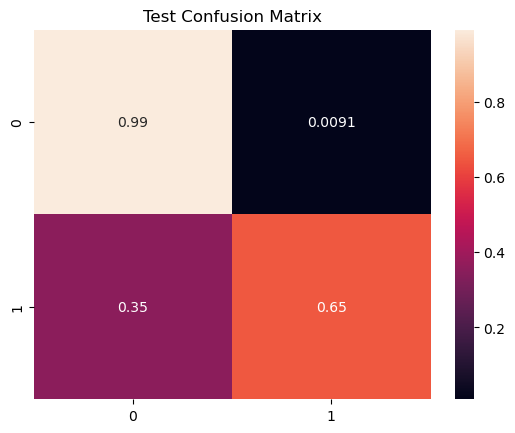

In [68]:
model_performance(xgb_model, y_test, X_test)

In [79]:
models =[clf, dc_pipe, rf_pipe, xgb_model]
accuracy_scores = []
roc_auc_scores = []


for model in models:
    train, test = evaluate_model(model, X_train, y_train, X_test, y_test)
    roc_auc_score_dc = roc_auc_score(y_test, model.predict(X_test))
    accuracy_scores.append(round(test * 100, 2))
    roc_auc_scores.append(round(roc_auc_score_dc, 3))

test_results_df = pd.DataFrame({
    'Model' : ['Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier', 'XGBoost Classifier'],
    'Accuracy': accuracy_scores,
    'roc_auc_score': roc_auc_scores
})

test_results_df

Train set accuracy: 88.47%
Test set Accuracy: 88.50%
Train set accuracy: 100.00%
Test set Accuracy: 92.94%
Train set accuracy: 100.00%
Test set Accuracy: 94.03%
Train set accuracy: 93.79%
Test set Accuracy: 93.79%


,Model,Accuracy,roc_auc_score
0,Logistic Regression,88.50,0.627
1,Decision Tree Classifier,92.94,0.861
2,Random Forest Classifier,94.03,0.823
3,XGBoost Classifier,93.79,0.819
